# Cardiac mechanics benchmark (Problem 3)
In this demo we will cover problem 3 in the cardiac mechanics benchmark problems in [Land2015](https://royalsocietypublishing.org/doi/10.1098/rspa.2015.0641).

>Land S, Gurev V, Arens S, Augustin CM, Baron L, Blake R, Bradley C, Castro S, Crozier A, Favino M, Fastl TE. Verification of cardiac mechanics software: benchmark problems and solutions for testing active and passive material behaviour. Proc. R. Soc. A. 2015 Dec 8;471(2184):20150641.

In [4]:
import matplotlib.pyplot as plt
import dolfin
import pulse

geometry = pulse.HeartGeometry.from_file(pulse.mesh_paths['benchmark'])

# Create the material
material_parameters = pulse.Guccione.default_parameters()
material_parameters['CC'] = 2.0
material_parameters['bf'] = 8.0
material_parameters['bfs'] = 4.0
material_parameters['bt'] = 2.0

activation = dolfin.Constant(0.0)
material = pulse.Guccione(params=material_parameters,
                          active_model='active_stress',
                          activation=activation)


# Define Dirichlet boundary. Fix the base_spring
def dirichlet_bc(W):
    V = W if W.sub(0).num_sub_spaces() == 0 else W.sub(0)
    return dolfin.DirichletBC(V, dolfin.Constant((0.0, 0.0, 0.0)),
                              geometry.ffun, geometry.markers['BASE'][0])


# Traction at the bottom of the beam
lvp = dolfin.Constant(0.0)
neumann_bc = pulse.NeumannBC(traction=lvp,
                             marker=geometry.markers['ENDO'][0])

# Collect Boundary Conditions
bcs = pulse.BoundaryConditions(dirichlet=(dirichlet_bc,),
                               neumann=(neumann_bc,))

# Create problem
problem = pulse.MechanicsProblem(geometry, material, bcs)

# Solve problem
pulse.iterate.iterate(problem, (lvp, activation), (15.0, 60.0),
                      initial_number_of_steps=20)

# Get displacement and hydrostatic pressure
u, p = problem.state.split(deepcopy=True)


endo_apex_marker = geometry.markers['ENDOPT'][0]
endo_apex_idx = geometry.vfun.array().tolist().index(endo_apex_marker)
endo_apex = geometry.mesh.coordinates()[endo_apex_idx, :]
endo_apex_pos = endo_apex + u(endo_apex)

print(('\n\nGet longitudinal position of endocardial apex: {:.4f} mm'
       '').format(endo_apex_pos[0]))


epi_apex_marker = geometry.markers['EPIPT'][0]
epi_apex_idx = geometry.vfun.array().tolist().index(epi_apex_marker)
epi_apex = geometry.mesh.coordinates()[epi_apex_idx, :]
epi_apex_pos = epi_apex + u(epi_apex)

print(('\n\nGet longitudinal position of epicardial apex: {:.4f} mm'
       '').format(epi_apex_pos[0]))

V = dolfin.VectorFunctionSpace(geometry.mesh, "CG", 1)
u_int = dolfin.interpolate(u, V)
mesh = dolfin.Mesh(geometry.mesh)
dolfin.ALE.move(mesh, u_int)

2019-05-22 07:51:06,070 - pulse.geometry_utils - INFO - 
Load mesh from h5
2019-05-22 07:51:06,374 - pulse.iterate - INFO - Control: [0.0, 0.0]
2019-05-22 07:51:06,375 - pulse.iterate - INFO - Target: [15.0, 60.0]
2019-05-22 07:51:06,377 - pulse.iterate - INFO - Check target reached: NO
2019-05-22 07:51:06,377 - pulse.iterate - INFO - Maximum difference: 6.000e+01
2019-05-22 07:51:06,378 - pulse.iterate - INFO - Try new control
2019-05-22 07:51:06,379 - pulse.iterate - INFO - Current control: 0.750,3.000
2019-05-22 07:51:09,515 - pulse.iterate - INFO - 
SUCCESFULL STEP:
2019-05-22 07:51:09,516 - pulse.iterate - INFO - Check target reached: NO
2019-05-22 07:51:09,517 - pulse.iterate - INFO - Maximum difference: 5.700e+01
2019-05-22 07:51:09,517 - pulse.iterate - INFO - Adapt step size. New step size: 1.125, 4.500
2019-05-22 07:51:09,518 - pulse.iterate - INFO - Check target reached: NO
2019-05-22 07:51:09,519 - pulse.iterate - INFO - Maximum difference: 5.700e+01
2019-05-22 07:51:09,520



Get longitudinal position of endocardial apex: 11.8550 mm


Get longitudinal position of epicardial apex: 15.4904 mm


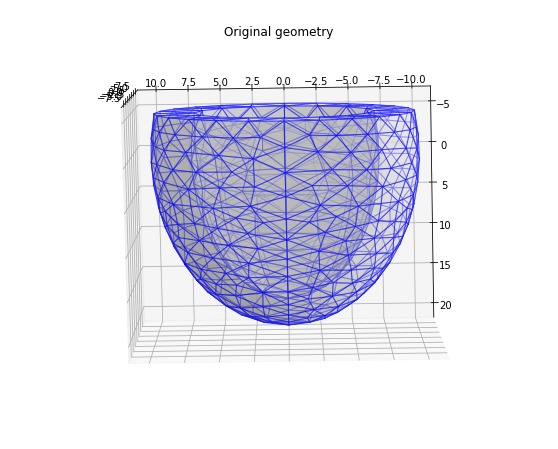

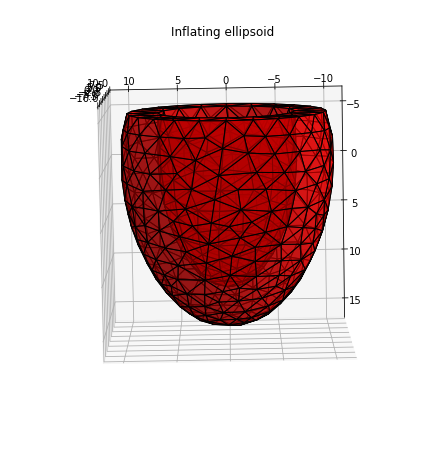

In [5]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (10,8)
plt.figure()
dolfin.plot(geometry.mesh, alpha=0.5, color='w',
            edgecolor='b', title='Original geometry')
ax1 = plt.gca()

plt.figure()
dolfin.plot(mesh, color='r', edgecolor='k', alpha=0.7,
            title='Inflating ellipsoid')
ax2 = plt.gca()

for ax in (ax1, ax2):
    ax.view_init(elev=-83, azim=-179)
plt.show()